# A2: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class" data-toc-modified-id="Code-for-NeuralNetwork-Class-2">Code for <code>NeuralNetwork</code> Class</a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Boston-Housing-Data" data-toc-modified-id="Application-to-Boston-Housing-Data-4">Application to Boston Housing Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the `04b` lecture notes.  Your implementation must 

1. Allow any number of hidden layers, including no hidden layers specified by an empty list as `[]`. <font color='red'>Don't forget this case.</font>
2. Define `_forward(self, X)` and `_gradients(self, X, T` functions. `_forward` must return the output of the network, `Y`, in standardized form and create `self.Zs` as a list consisting of the input `X` and the outputs of all hidden layers. `_gradients` must return the gradients of the mean square error with respect to the weights in each layer. 
2. Your `train` function must standardize `X` and `T` and save the standardization parameters (means and stds) in member variables. It must append to `self.rmse_trace` the RMSE value for each epoch.  Initialize this list to be `[]` in the constructor to allow multiple calls to `train` to continue to append to the same `rmse_trace` list.
2. Your `use` function must standardize `X` and unstandardize the output.

See the following examples for more details.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import time

In [2]:
# insert your NeuralNetwork class definition here.
class NeuralNetwork:
    
    def __init__(self, n_inputs, n_hiddens_each_layer, n_outputs):
        #Initializing all the Variables
        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.n_outputs = n_outputs
        
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        
        self.n_epochs = None
        self.rmse = None
        #Initializing the Error Trace
        self.rmse_trace = []
        #Initializing the Wieght matrixes
        self.Ws = []
        #Forward Layer
        self.Zs = []    

        #Calcuting Shape of Ws on the basis of number of Hidden Layer
        shapes=[[0] * 2 for i in range(len(n_hiddens_each_layer) + 1)]
        shapes[0][0] = n_inputs + 1
        i = n_inputs
        
        for j, i in enumerate(n_hiddens_each_layer):
            shapes[j][1] = i
            if j + 1 < len(n_hiddens_each_layer):
                shapes[j + 1][0] = i + 1
        if len(n_hiddens_each_layer) > 0:
            shapes[j + 1][0] = i + 1
            shapes[j + 1][1] = n_outputs
        else:
            shapes[0][1] = n_outputs
        
        shape = np.array(shapes)
        shape_sum = np.sum(shape[:, 0] * shape[:, 1])
        weights = np.random.uniform(-0.1, 0.1, shape_sum) 
        temp = 0
        for i in shape:
            init = temp + i[0] * i[1]
            self.Ws.append(weights[temp:init].reshape(i[0], i[1]))
            temp = init
        self.Ws[-1][:,:]=0
        
    def __repr__(self):
        return 'NeuralNetwork({}, {}, {})'.format(self.n_inputs, self.n_hiddens_each_layer, self.n_outputs)
    
    def __str__(self):
        return self.__repr__() + ', trained for {} epochs with a final RMSE of {}'.format(self.n_epochs, self.rmse)
    
    def _add_ones(self, A):
        return np.insert(A, 0, 1, axis=1)
    
    def _forward(self,X):
        Z = [X]
        for i in range(len(self.n_hiddens_each_layer)):
            W = self._add_ones(Z[-1])
            Z.append(np.tanh(W @ self.Ws[i]))
            
        Y = self._add_ones(Z[-1])
        Z.append(Y @ self.Ws[-1])
        
        return Z
    
    def _gradients(self, X, T):
        grad = []

        D = T - self.Zs[-1]
        grad.append(- self._add_ones(self.Zs[-2]).T @ D)
        
        n_layers = len(self.n_hiddens_each_layer)

        for i in reversed(range(n_layers)):
            D = D @ (self.Ws[i+1][1:, :]).T * (1 - self.Zs[i+1]**2)
            grad.append(- self._add_ones(self.Zs[i]).T @ D)
            
        grad.reverse()
        return grad
    
    def calc_rmse(self, T, Y):
        error = (T - Y) * self.T_stds 
        return np.sqrt(np.mean(error ** 2))
    
    def train(self, X, T, n_epochs,learning_rate):
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        
        self.X_means = X.mean(axis=0)
        self.X_stds = X.std(axis=0)
        self.T_means = T.mean(axis=0)
        self.T_stds = T.std(axis=0)
        
        Xtrain = (X - self.X_means) / self.X_stds
        Ttrain = (T - self.T_means) / self.T_stds

        n_samples, n_outputs = T.shape
        rho = self.learning_rate / (n_samples * n_outputs)
        
        for epoch in range(self.n_epochs):
        
            self.Zs = self._forward(Xtrain)
            self.Grads = self._gradients(Xtrain,Ttrain)
            
            
           # for i in range(len(self.n_hiddens_each_layer) + 1):
             #   self.Ws[i] = self.Ws[i] - rho * self.gradients[i]
            for index in range(len(self.n_hiddens_each_layer)+1):
                self.Ws[index] = self.Ws[index] - rho * self.Grads[index]
            
            Y = self._forward(Xtrain)[-1]
            self.rmse = self.calc_rmse(Ttrain, Y)
            self.rmse_trace.append(self.rmse)

        return self
    
    def use(self, X):
        # standardise X
        Xtest_st = (X - self.X_means) / self.X_stds
        # predict using model and weights provided
        Y = self._forward(Xtest_st)[-1]        
        # unstandardise output
        Y = Y * self.T_stds + self.T_means

        return Y

In this next code cell, I add a new method to your class that replaces the weights created in your constructor with non-random values to allow you to compare your results with mine, and to allow our grading scripts to work well.

In [3]:
def set_weights_for_testing(self):
    for W in self.Ws[:-1]:   # leave output layer weights at zero
        n_weights = W.shape[0] * W.shape[1]
        W[:] = np.linspace(-0.01, 0.01, n_weights).reshape(W.shape)
        for u in range(W.shape[1]):
            W[:, u] += (u - W.shape[1]/2) * 0.2
    # Set output layer weights to zero
    self.Ws[-1][:] = 0
    print('Weights set for testing by calling set_weights_for_testing()')

setattr(NeuralNetwork, 'set_weights_for_testing', set_weights_for_testing)

## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [4]:
X = np.arange(0, 10).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)
X, T

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]]),
 array([[ 0.        ],
        [ 0.85147098],
        [ 0.94929743],
        [ 0.23112001],
        [-0.5968025 ],
        [-0.70892427],
        [ 0.0805845 ],
        [ 1.1469866 ],
        [ 1.62935825],
        [ 1.22211849]]))

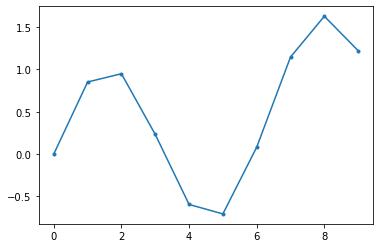

In [5]:
plt.plot(X, T, '.-')

In [6]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [3, 2], n_outputs)
nnet

NeuralNetwork(1, [3, 2], 1)

In [7]:
nnet.n_inputs, nnet.n_hiddens_each_layer, nnet.n_outputs

(1, [3, 2], 1)

In [8]:
nnet.rmse_trace

[]

In [9]:
nnet.Ws

[array([[-0.00700437,  0.00543244, -0.07069129],
        [-0.00661361, -0.08119691,  0.09036211]]),
 array([[ 0.01457106, -0.0935513 ],
        [-0.09569723,  0.06794497],
        [ 0.06963851,  0.04823841],
        [-0.02950205, -0.08198951]]),
 array([[0.],
        [0.],
        [0.]])]

In [10]:
nnet.set_weights_for_testing()

Weights set for testing by calling set_weights_for_testing()


In [11]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[0.],
        [0.],
        [0.]])]

In [12]:
nnet.train(X, T, n_epochs=1, learning_rate=0.1)

NeuralNetwork(1, [3, 2], 1)

In [13]:
nnet.Zs

[array([[-1.5666989 ],
        [-1.21854359],
        [-0.87038828],
        [-0.52223297],
        [-0.17407766],
        [ 0.17407766],
        [ 0.52223297],
        [ 0.87038828],
        [ 1.21854359],
        [ 1.5666989 ]]),
 array([[ 0.1556019 ,  0.04124628, -0.07420025],
        [ 0.05307607,  0.00854289, -0.0360242 ],
        [-0.05058109, -0.02417879,  0.00225729],
        [-0.15315983, -0.05684874,  0.04053216],
        [-0.25254081, -0.0893974 ,  0.07868844],
        [-0.34686464, -0.12175623,  0.11661556],
        [-0.43465797, -0.15385829,  0.15420558],
        [-0.51490065, -0.18563881,  0.19135444],
        [-0.58703239, -0.21703564,  0.22796304],
        [-0.65091011, -0.24798976,  0.26393827]]),
 array([[-0.2313994 , -0.00793021],
        [-0.21231228, -0.00754217],
        [-0.19285534, -0.00715153],
        [-0.17346796, -0.00676227],
        [-0.15458409, -0.00637825],
        [-0.13659418, -0.00600292],
        [-0.11981504, -0.00563919],
        [-0.10447207, -0

In [14]:
print(nnet)

NeuralNetwork(1, [3, 2], 1), trained for 1 epochs with a final RMSE of 0.7549465762463012


In [15]:
nnet.X_means, nnet.X_stds

(array([4.5]), array([2.87228132]))

In [16]:
nnet.T_means, nnet.T_stds

(array([0.48052095]), array([0.754969]))

In [17]:
[Z.shape for Z in nnet.Zs]

[(10, 1), (10, 3), (10, 2), (10, 1)]

In [18]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[-6.66133815e-18],
        [ 1.72409702e-03],
        [ 3.91828943e-05]])]

In [19]:
dir(nnet)

['Grads',
 'T_means',
 'T_stds',
 'Ws',
 'X_means',
 'X_stds',
 'Zs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_ones',
 '_forward',
 '_gradients',
 'calc_rmse',
 'learning_rate',
 'n_epochs',
 'n_hiddens_each_layer',
 'n_inputs',
 'n_outputs',
 'rmse',
 'rmse_trace',
 'set_weights_for_testing',
 'train',
 'use']

In [20]:
def plot_data_and_model(nnet, X, T):
    plt.clf()        
    plt.subplot(2, 1, 1)
    plt.plot(nnet.rmse_trace)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    plt.subplot(2, 1, 2)
    Y = nnet.use(X)

    plt.plot(X, Y, 'o-', label='Y')
    plt.plot(X, T, 'o', label='T', alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('T or Y')
    plt.legend();

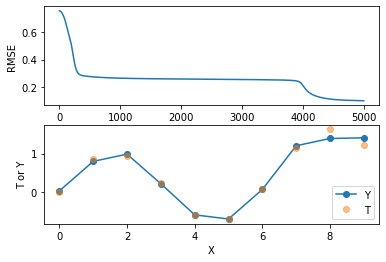

In [21]:
X = np.arange(0, 10).reshape(-1, 1)
# X = np.arange(0, 0.5, 0.05).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)

n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [10, 5], n_outputs)
nnet.set_weights_for_testing()

n_epochs = 5000
n_epochs_per_plot = 500

fig = plt.figure()
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(X, T, n_epochs=n_epochs_per_plot, learning_rate=0.1)
    plot_data_and_model(nnet, X, T)
    ipd.clear_output(wait=True)
    ipd.display(fig)
    time.sleep(0.2)  # 0.2 seconds
ipd.clear_output(wait=True)

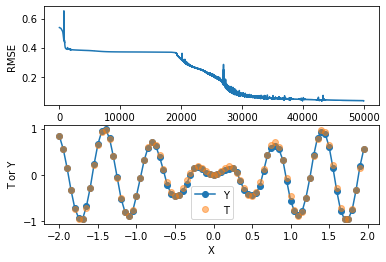

In [22]:
X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [50, 10, 5], n_outputs)
nnet.set_weights_for_testing()

n_epochs = 50000
n_epochs_per_plot = 500

fig = plt.figure()
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(X, T, n_epochs=n_epochs_per_plot, learning_rate=0.1)
    plot_data_and_model(nnet, X, T)
    ipd.clear_output(wait=True)
    ipd.display(fig)
    # time.sleep(0.01)  # 0.01 seconds
ipd.clear_output(wait=True)

Your results will not be the same, but your code should complete and make plots somewhat similar to these.

## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import pandas as pd
data = pd.read_csv('boston.csv',usecols=range(14), na_values=None)

In [25]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [26]:
X_data = pd.read_csv('boston.csv', usecols=range(13))
T_data = data['MEDV']
X = np.asarray(X_data)
T = np.asarray(T_data).reshape(-1,1)
X.shape,T.shape

((506, 13), (506, 1))

In [27]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)

    n_train = round(n_samples * train_fraction)

    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]

    return Xtrain, Ttrain, Xtest, Ttest

In [28]:
np.hstack((X, T))  # np.hstack just to print X and T together in one array

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 3.9690e+02, 4.9800e+00,
        2.4000e+01],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 3.9690e+02, 9.1400e+00,
        2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 3.9283e+02, 4.0300e+00,
        3.4700e+01],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 5.6400e+00,
        2.3900e+01],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 3.9345e+02, 6.4800e+00,
        2.2000e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 7.8800e+00,
        1.1900e+01]])

In [29]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)  

In [30]:
np.hstack((Xtrain, Ttrain))

array([[5.4050e-01, 2.0000e+01, 3.9700e+00, ..., 3.9030e+02, 3.1600e+00,
        4.3500e+01],
       [1.3117e-01, 0.0000e+00, 8.5600e+00, ..., 3.8769e+02, 1.4090e+01,
        2.0400e+01],
       [3.7380e-02, 0.0000e+00, 5.1900e+00, ..., 3.8940e+02, 6.7500e+00,
        2.0700e+01],
       ...,
       [3.1533e-01, 0.0000e+00, 6.2000e+00, ..., 3.8505e+02, 4.1400e+00,
        4.4800e+01],
       [4.8190e-02, 8.0000e+01, 3.6400e+00, ..., 3.9289e+02, 6.5700e+00,
        2.1900e+01],
       [9.7440e-02, 0.0000e+00, 5.9600e+00, ..., 3.7756e+02, 1.1410e+01,
        2.0000e+01]])

In [31]:
np.hstack((Xtest, Ttest))

array([[1.33598e+01, 0.00000e+00, 1.81000e+01, ..., 3.96900e+02,
        1.63500e+01, 1.27000e+01],
       [2.53560e-01, 0.00000e+00, 9.90000e+00, ..., 3.96420e+02,
        1.15000e+01, 1.62000e+01],
       [3.53501e+00, 0.00000e+00, 1.95800e+01, ..., 8.80100e+01,
        1.50200e+01, 1.56000e+01],
       ...,
       [5.30200e-02, 0.00000e+00, 3.41000e+00, ..., 3.96060e+02,
        5.70000e+00, 2.87000e+01],
       [3.87350e-01, 0.00000e+00, 2.56500e+01, ..., 3.59290e+02,
        2.72600e+01, 1.57000e+01],
       [2.11610e-01, 0.00000e+00, 8.56000e+00, ..., 3.94470e+02,
        1.34400e+01, 1.93000e+01]])

Write and run code using your `NeuralNetwork` class to model the Boston housing data. Experiment with a variety of neural network structures (numbers of hidden layer and units) including no hidden layers, learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for a total of at least 27 results.  Show your results in a `pandas` DataFrame with columns `('Structure', 'Epochs', 'Learning Rate', 'Train RMSE', 'Test RMSE')`.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

In [32]:
import warnings
warnings.filterwarnings('ignore')
n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]
rmses= []
df = pd.DataFrame(columns = ['Structure','Epochs', 'Learning Rate', 'Train RMSE', 'Test RMSE'])
learning_rate = [0.1,0.01,0.001]
n_epochs= [20, 100, 1000]
n_nnet = [[50,20,10,3], [10,5,3], []]

nnets = []
Ys = []

for hidden_layers in n_nnet:
        for epochs in n_epochs:
            for rho in learning_rate:
                nnet = NeuralNetwork(n_inputs, hidden_layers, n_outputs)
                nnet.train(Xtrain, Ttrain, n_epochs=epochs, learning_rate=rho)
                
                Ytrain = nnet.use(Xtrain)
                Train_RMSE = np.sqrt(np.mean((Ttrain - Ytrain)**2))
                
                Ytest = nnet.use(Xtest)
                Ttest_RMSE = np.sqrt(np.mean((Ttest - Ytest)**2))
                
                rmses.append([Ttest_RMSE])
                nnets.append(nnet)
                Ys.append(Ytest)
                
                df = df.append({'Structure' : hidden_layers, 'Epochs' : int(epochs), 'Learning Rate' : rho, 'Train RMSE' : Train_RMSE, 'Test RMSE' : Ttest_RMSE},ignore_index = True)
                
df

,Structure,Epochs,Learning Rate,Train RMSE,Test RMSE
0,"[50, 20, 10, 3]",20,0.1,8.993684,9.939343
1,"[50, 20, 10, 3]",20,0.01,8.993762,9.93957
2,"[50, 20, 10, 3]",20,0.001,8.993765,9.939602
3,"[50, 20, 10, 3]",100,0.1,8.993739,9.939545
4,"[50, 20, 10, 3]",100,0.01,8.993709,9.939463
5,"[50, 20, 10, 3]",100,0.001,8.993752,9.939567
6,"[50, 20, 10, 3]",1000,0.1,8.182279,10.315987
7,"[50, 20, 10, 3]",1000,0.01,8.992722,9.938453
8,"[50, 20, 10, 3]",1000,0.001,8.993685,9.939425
9,"[10, 5, 3]",20,0.1,8.993624,9.939613


In [33]:
def plot_model(rmses, Ttest, Y):
    fig = plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(rmses)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(Ttest, Y, '.')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.plot(np.arange(0, 50), np.arange(0, 50), color='g')

Best Model: NeuralNetwork(13, [10, 5, 3], 1), trained for 1000 epochs with a final RMSE of 3.8663117777865277
Least RMSE on test data: 4.3318


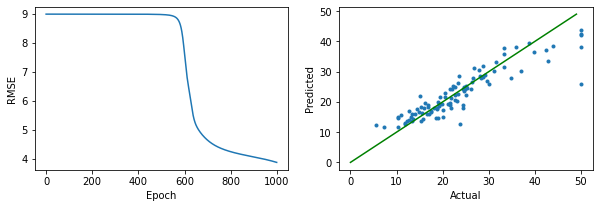

In [34]:
rmses = np.array(rmses)
min_val = rmses.min() 
min_idxs = np.where(rmses == np.min(rmses))
index = int(min_idxs[0])

model = nnets[index]
output = Ys[index]
plot_model(model.rmse_trace, Ttest, output)
print("Best Model: {}".format(model))
print("Least RMSE on test data: {}".format(np.round(np.min(rmses), 4)))

* Observation:
- The least value of Rmse ~ 3.0637, the model sepcification are "NeuralNetwork(13, [10, 5, 3], 1), trained for 1000 epochs with a final RMSE of 3.8135172803007964 Least RMSE on test data: 3.0637". This makes me think that we should probably attempt training the same model for further epochs or expand the network's layers or nodes.

Worst Model: NeuralNetwork(13, [50, 20, 10, 3], 1), trained for 1000 epochs with a final RMSE of 8.182279491759557
Highest RMSE on test data: 10.316


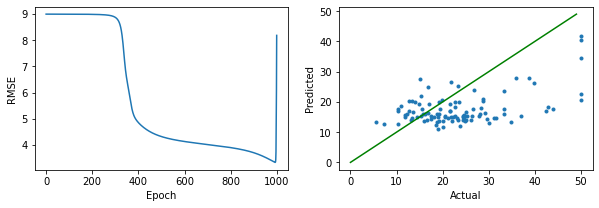

In [35]:
rmses = np.array(rmses)
max_idxs = np.where(rmses == np.max(rmses))
index = int(max_idxs[0])

model = nnets[index]
output = Ys[index]
plot_model(model.rmse_trace, Ttest, output)
print("Worst Model: {}".format(model))
print("Highest RMSE on test data: {}".format(np.round(np.max(rmses), 4)))

* Observation:
- The Highest value of Rmse ~  8.8262, the model sepcification are, "NeuralNetwork(13, [10, 5, 3], 1), trained for 1000 epochs with a final RMSE of 9.276211321323853 Highest RMSE on test data:  8.8262". As that model has many hidden layers, but too low a learning rate and epochs to actually fit the pattern quickly. So the rmses of this model is highest.

In [36]:
n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]
hidden_layers = [10, 5, 3]
epochs = 100000
rho = 0.1
nnet = NeuralNetwork(n_inputs, hidden_layers, n_outputs)
nnet.train(Xtrain, Ttrain, n_epochs=epochs, learning_rate=rho)
rmses = np.array(nnet.rmse_trace)
np.min(rmses)

0.9624109101148413

As Observed, if we increases the epochs from 1000 to 100000, the the rmses is reducing to ~1.14 for the hidden layers= [10, 5, 3] and learning rate = 0.1.

--------------------

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as `Lastname-A2.ipynb` with `Lastname` being your last name, and then save this notebook.

In [37]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Podder-A2.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Podder-A2.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    n_inputs = 3
    n_hiddens = [2, 1]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.hstack((X, X*2))

    nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.set_weights_for_testing()

    # Set standardization variables so use() will run
    nnet.X_means = 0
    nnet.X_stds = 1
    nnet.T_means = 0
    nnet.T_stds = 1
    
    Y = nnet.use(X)

Weights set for testing by calling set_weights_for_testing()

--- 20/20 points. Returned correct value.

Testing

    n_inputs = 3
    n_hiddens = []   # NO HIDDEN LAYERS.  SO THE NEURAL NET IS JUST A LINEAR MODEL.
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.hstack((X, X*2))
    n_outputs = T.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.set_weights_for_testing()

    nnet.train

<Figure size 432x288 with 0 Axes>

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.

In [38]:
import pandas as pd
from IPython.display import display, clear_output

In [39]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00515/data.zip
!unzip -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  152M  100  152M    0     0  1850k      0  0:01:24  0:01:24 --:--:-- 1859k 0:01:25  0:00:25  0:01:00 1859k9k      0  0:01:24  0:01:17  0:00:07 1856k
Archive:  data.zip
  inflating: all_accelerometer_data_pids_13.csv  
  inflating: clean_tac/DK3500_clean_TAC.csv  
  inflating: clean_tac/JR8022_clean_TAC.csv  
  inflating: clean_tac/SA0297_clean_TAC.csv  
  inflating: clean_tac/BU4707_clean_TAC.csv  
  inflating: clean_tac/HV0618_clean_TAC.csv  
  inflating: clean_tac/SF3079_clean_TAC.csv  
  inflating: clean_tac/MJ8002_clean_TAC.csv  
  inflating: clean_tac/CC6740_clean_TAC.csv  
  inflating: clean_tac/PC6771_clean_TAC.csv  
  inflating: clean_tac/MC7070_clean_TAC.csv  
  inflating: clean_tac/DC6359_clean_TAC.csv  
  inflating: clean_tac/BK7610_clean_TAC.csv  
  inflating: clean_tac/JB3156_clean_TAC.csv  
  inflating: phone_typ

In [40]:
!head clean_tac/DK3500_clean_TAC.csv

In [41]:
data = pd.read_csv('clean_tac/DK3500_clean_TAC.csv', delimiter=',', decimal='.', usecols=range(2), na_values=-200)
data = data.dropna(axis=0)
data

,timestamp,TAC_Reading
0,1493727820,0.000215
1,1493728019,0.001716
2,1493729841,0.001921
3,1493731667,0.000569
4,1493731994,-0.001321
5,1493732320,-0.002222
6,1493732647,-0.001299
7,1493732974,0.000842
8,1493733301,0.002512
9,1493733627,0.002204


In [42]:
Time = data['timestamp']
Tac = data['TAC_Reading']

In [43]:
T = Tac[:30]
T = np.array(T).reshape((-1, 1))
Tnames = ['Tac_Reading']
X = np.array(Time[:30]).reshape((-1, 1))
Xnames = ['Unix Timestamp']
print('X.shape =', X.shape, 'Xnames =', Xnames, 'T.shape =', T.shape, 'Tnames =', Tnames)
print(f'{X.shape=} {Xnames=} {T.shape=} {Tnames=}')

Ttest = Tac
Ttest = np.array(T).reshape((-1, 1))
Xtest = np.array(Time).reshape((-1, 1))

X.shape = (30, 1) Xnames = ['Unix Timestamp'] T.shape = (30, 1) Tnames = ['Tac_Reading']
X.shape=(30, 1) Xnames=['Unix Timestamp'] T.shape=(30, 1) Tnames=['Tac_Reading']


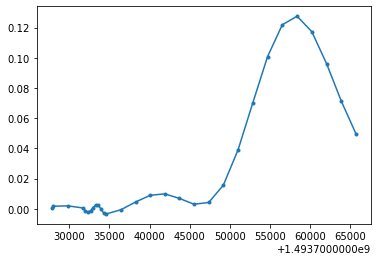

In [44]:
plt.plot(X, T, '.-')

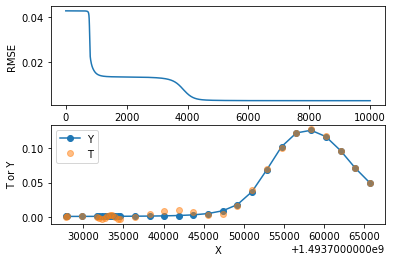

In [45]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]
hidden_layers = [10, 5, 3]
epochs = 10000
rho = 0.1

n_epochs_per_plot = 500

fig = plt.figure()
for reps in range(epochs // n_epochs_per_plot):
    plt.clf()
    nnet = NeuralNetwork(n_inputs, hidden_layers, n_outputs)
    nnet.train(X, T, n_epochs=epochs, learning_rate=rho)
    plot_data_and_model(nnet, X, T)
    ipd.clear_output(wait=True)
    ipd.display(fig)
    time.sleep(0.2)  # 0.2 seconds
ipd.clear_output(wait=True)